In [1]:
import psycopg2
import pandas as pd
import numpy as np
import mariadb
import json
import os
import shutil
import subprocess
from pathlib import Path
import pyodbc
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.spatial import distance
import pickle
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
import seaborn as sns

In [2]:
analysisDetails = pd.read_csv("output/analysis_chemicals.csv")

In [3]:
analysisDetails.analysis_name = [ i.replace(":","") for i in analysisDetails.analysis_name ]

In [4]:
analysisDetails['chemical_name'] = [ i.replace("'","").replace("[","").replace("]","").split(",") for i in analysisDetails['chemical_name'] ]

In [5]:
analysisDetails = analysisDetails.set_index("analysis_name")

In [6]:
analysisDetails = analysisDetails.to_dict()['chemical_name']

In [7]:
analysisDetails['Aluminium Analysis (Media)'] = analysisDetails['Aluminium Analysis']

In [8]:
hydroponics_df = pd.read_csv("output/hydroponics_analysis_cleaned.csv")

In [9]:
hydroponics_df

,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,sample_code,batch_date,analysis_name,chemical_name,result,unit_name
0,29,525705,525705,CC003HY0107,2023-03-29 10:46:00.000,Drain Water Analysis,bicarbonate,260.0,ppm
1,117,520391,520391,CO006HY0294,2023-03-30 15:13:00.000,Drain Water Analysis,bicarbonate,79.8,ppm
2,118,521381,521381,CO006HY0292,2023-03-30 15:13:00.000,Drain Water Analysis,bicarbonate,44.9,ppm
3,165,519730,519730,CE361HY0019,2023-03-30 15:59:00.000,Drain Water Analysis,bicarbonate,153.0,ppm
4,196,525725,525725,CE361HY0017,2023-03-30 15:59:00.000,Drain Water Analysis,bicarbonate,83.7,ppm
...,...,...,...,...,...,...,...,...,...
1078128,142541,648932,648932,CO148HY0139,2024-10-14 17:39:00.000,Bacterial test (9) in hydroponics,total_coliforms,100.0,cfu/100 ml
1078129,134070,653827,653827,CC370HY0004,2024-09-10 12:31:00.000,Bacterial test (9) in hydroponics,listeria_monocytogenes,0.0,cfu/ml
1078130,134070,653827,653827,CC370HY0004,2024-09-10 12:31:00.000,Bacterial test (9) in hydroponics,listeria_monocytogenes,0.0,cfu/ml
1078131,134060,653824,653824,CC370HY0004,2024-09-10 12:31:00.000,Bacterial test (9) in hydroponics,e_coli,0.0,cfu/ml


In [10]:
hydroponics_df.analysis_name.value_counts().to_csv("output/analysis_value_counts.csv")

In [11]:
hydroponics_df.analysis_name = [ str(i).strip() for i in hydroponics_df.analysis_name]

In [12]:
hydroponics_df['analysis_name'] = [i.replace(":","") for i in hydroponics_df['analysis_name']]
hydroponics_df['result'] = [ float(str(i).replace("<","").replace(">","")) for i in hydroponics_df['result'] ]

In [13]:
hydroponics_df.sort_values('batch_date')

,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,sample_code,batch_date,analysis_name,chemical_name,result,unit_name
873192,151011,22469,22469,CF006HY0131,2011-06-09 00:00:00.000,Drip Water Analysis,magnesium,3.000,ppm
873191,150994,22478,22478,CF006HY0130,2011-06-09 00:00:00.000,Drip Water Analysis,magnesium,15.000,ppm
614415,150997,22475,22475,CF006HY0131,2011-06-09 00:00:00.000,Drip Water Analysis,manganese,0.190,ppm
827086,151019,22480,22480,CF006HY0130,2011-06-09 00:00:00.000,Drip Water Analysis,phosphorus,23.000,ppm
827085,151001,22471,22471,CF006HY0131,2011-06-09 00:00:00.000,Drip Water Analysis,phosphorus,1.000,ppm
...,...,...,...,...,...,...,...,...,...
1026316,150989,651503,651503,CK013HY0039,2024-11-15 16:33:35.790,Substrate Analysis (Cocos) 11.5 Volume Extract,copper,0.025,ppm
1050435,150975,651496,651496,CK013HY0039,2024-11-15 16:33:35.790,Substrate Analysis (Cocos) 11.5 Volume Extract,nitrate_n,16.800,ppm
1051435,150981,651495,651495,CK013HY0039,2024-11-15 16:33:35.790,Substrate Analysis (Cocos) 11.5 Volume Extract,phosphorus,8.120,ppm
1045417,150989,651503,651503,CK013HY0039,2024-11-15 16:33:35.790,Substrate Analysis (Cocos) 11.5 Volume Extract,copper,0.025,ppm


In [14]:
new_samples_df = hydroponics_df.loc[hydroponics_df['batch_date'] > '2024-08-21'] 
hydroponics_df = hydroponics_df.loc[hydroponics_df['batch_date'] <= '2024-08-21'] 

In [15]:
new_samples_df.analysis_name.value_counts()

analysis_name
Drain Water Analysis                               6831
Drip Water Analysis                                6708
Substrate Analysis (Cocos) 11.5 Volume Extract      844
Substrate Analysis (Pumice) 11.5 Volume Extract     618
Raw irrigation water analysis (for fertigation)     494
Recycle Water Analysis                              409
Bacterial test (9) in hydroponics                    18
Name: count, dtype: int64

In [16]:
hydroponics_df.analysis_name.value_counts()

analysis_name
Drain Water Analysis                               525318
Drip Water Analysis                                415468
Substrate Analysis (Pumice) 11.5 Volume Extract     64147
Substrate Analysis (Cocos) 11.5 Volume Extract      34297
Recycle Water Analysis                              10703
Raw irrigation water analysis (for fertigation)      7620
Fluoride Analysis                                    1387
Heavy metals in Hydroponics                          1315
Fluoride Analysis (Media)                             597
Fluoride Analysis (Drip)                              455
Fluoride Analysis (Drain)                             387
Aluminium Analysis (Media)                            375
Selected elements (ICP) Analysis                       52
Sample digestion                                       52
E coli & Total Coliforms                               20
Aqua regia - Selected elements (ICP) Analysis          18
Name: count, dtype: int64

In [17]:
hydroponics_df.analysis_name.value_counts().to_csv("output/modelling_analysis_value_counts.csv")
new_samples_df.analysis_name.value_counts().to_csv("output/test_analysis_value_counts.csv")

In [18]:
os.makedirs("output/analysis",exist_ok=True)
os.makedirs("output/chemical_null_count",exist_ok=True)

for analysis in np.unique(hydroponics_df['analysis_name']):
    print(analysis)
    if analysis not in analysisDetails.keys():
        continue
    df_ = hydroponics_df.loc[hydroponics_df['analysis_name']==analysis]
    print(df_.chemical_name.unique())
    
    df_ = pd.pivot_table(data=df_, values="result", index="sample_code", columns="chemical_name")
    df_ = df_[[ j.strip() for j in analysisDetails[analysis] if j.strip() in df_.columns]]
    df_ = df_.loc[:, ~df_.columns.duplicated()]

    os.makedirs(f"output/boxplots/{analysis}",exist_ok=True)
    for column in df_.columns:        
        plt.boxplot(df_[column])
        plt.savefig(f"output/boxplots/{analysis}/{column}.png")
        plt.clf()
        outlier_threshold = df_[column].quantile(0.99)
        # df_ = df_.loc[df_[column] <= outlier_threshold]

    if len(df_.columns) == 0:
        continue
    df_.describe().to_csv(f"output/chemical_null_count/{analysis}.csv")
    
    df_.to_csv(f"output/analysis/{analysis}.csv")


Aluminium Analysis (Media)
['aluminium' 'molybdenum' 'copper' 'boron' 'zinc' 'iron' 'calcium'
 'sodium' 'sulphur' 'silicon__' 'potassium' 'phosphorus' 'magnesium'
 'manganese' 'bicarbonate' 'ammonium' 'nitrate_n' 'nitrates' 'chloride']
Aqua regia - Selected elements (ICP) Analysis
['arsenic' 'cadmium' 'chromium' 'cobalt' 'lead' 'nickel']
Drain Water Analysis
['bicarbonate' 'potassium' 'sodium' 'sulphur' 'ammonium' 'nitrate_n'
 'phosphorus' 'magnesium' 'copper' 'molybdenum' 'boron' 'calcium'
 'manganese' 'zinc' 'iron' 'silicon__' 'chloride' 'nitrates' 'chlorides'
 'electrical_conductivity' 'fluoride' 'aluminium']
Drip Water Analysis
['bicarbonate' 'sodium' 'phosphorus' 'potassium' 'zinc' 'sulphur' 'iron'
 'manganese' 'calcium' 'molybdenum' 'copper' 'nitrate_n' 'boron'
 'magnesium' 'ammonium' 'silicon__' 'chloride' 'nitrates' 'chlorides'
 'electrical_conductivity' 'fluoride' 'aluminium']
E coli & Total Coliforms
['e_coli' 'total_coliforms']
Fluoride Analysis
['manganese' 'chloride' 'sulp

<Figure size 640x480 with 0 Axes>

In [19]:
os.makedirs("./output/analysis_imputed",exist_ok=True)
os.makedirs("./output/pca_plots",exist_ok=True)
os.makedirs("./output/pca_df",exist_ok=True)
os.makedirs("./output/analysis_scaled",exist_ok=True)

In [20]:
os.makedirs("./models/imputers",exist_ok=True)
os.makedirs("./models/scalers",exist_ok=True)
os.makedirs("./models/pca",exist_ok=True)

Aluminium Analysis (Media).csv
Drain Water Analysis.csv
Number of components explaining 95% variance: 11
Drip Water Analysis.csv
Number of components explaining 95% variance: 10
E coli & Total Coliforms.csv
Number of components explaining 95% variance: 1
Fluoride Analysis (Drain).csv
Fluoride Analysis (Media).csv
Number of components explaining 95% variance: 2
Fluoride Analysis.csv
Number of components explaining 95% variance: 2
Heavy metals in Hydroponics.csv
Number of components explaining 95% variance: 6
Raw irrigation water analysis (for fertigation).csv
Number of components explaining 95% variance: 11
Recycle Water Analysis.csv
Number of components explaining 95% variance: 11
Selected elements (ICP) Analysis.csv
Number of components explaining 95% variance: 3
Substrate Analysis (Cocos) 11.5 Volume Extract.csv
Number of components explaining 95% variance: 13
Substrate Analysis (Pumice) 11.5 Volume Extract.csv
Number of components explaining 95% variance: 10


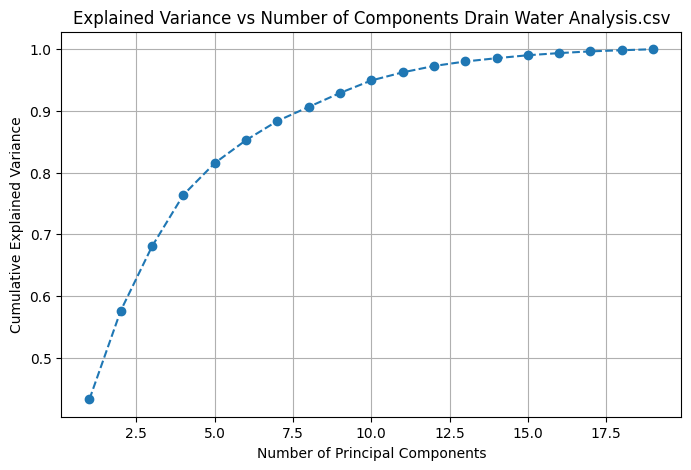

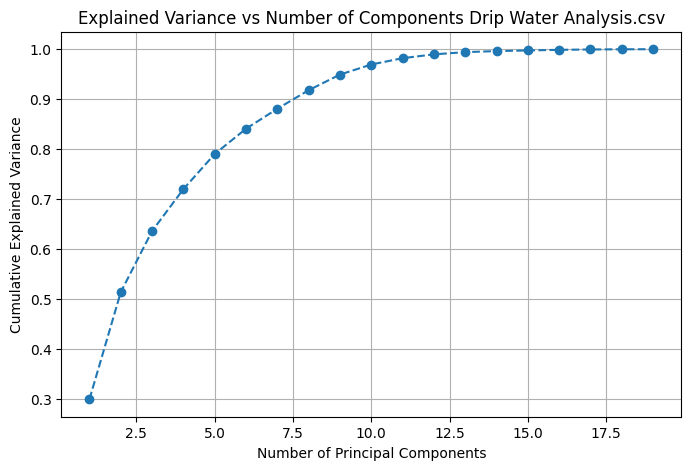

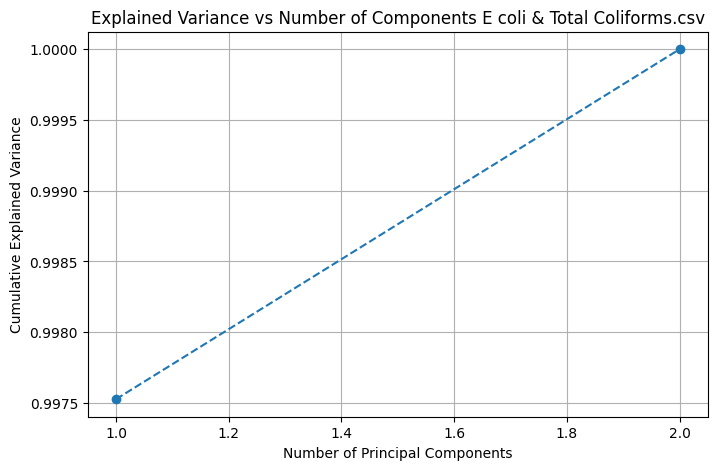

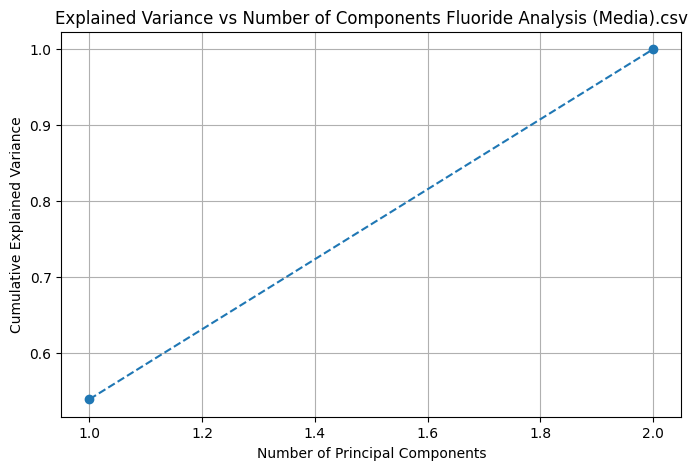

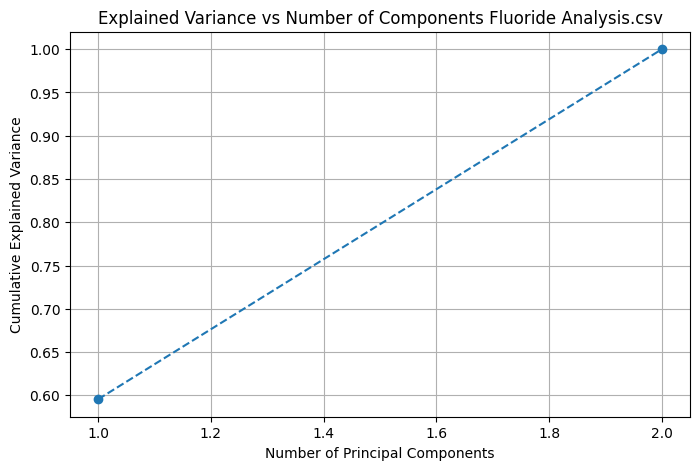

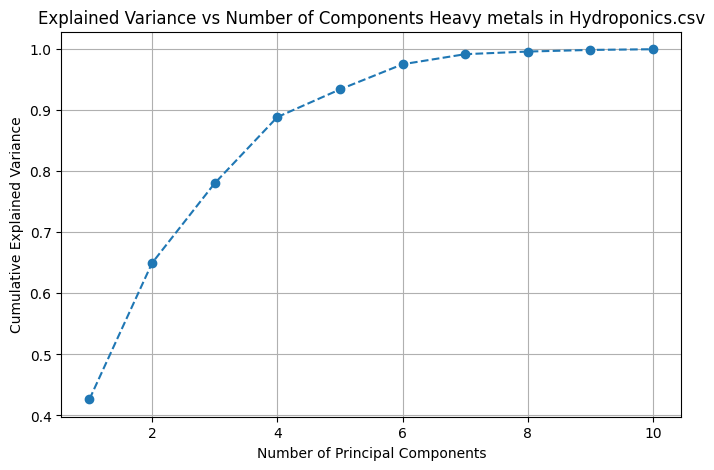

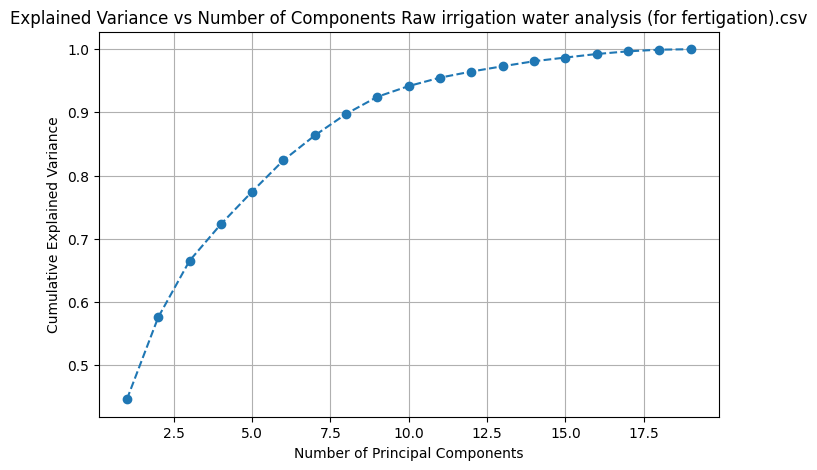

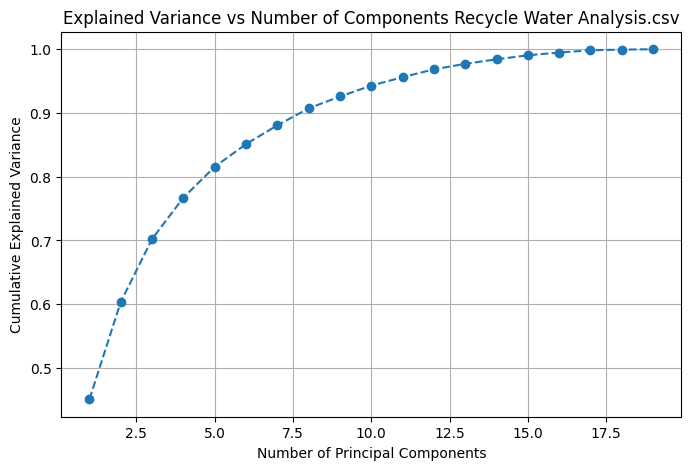

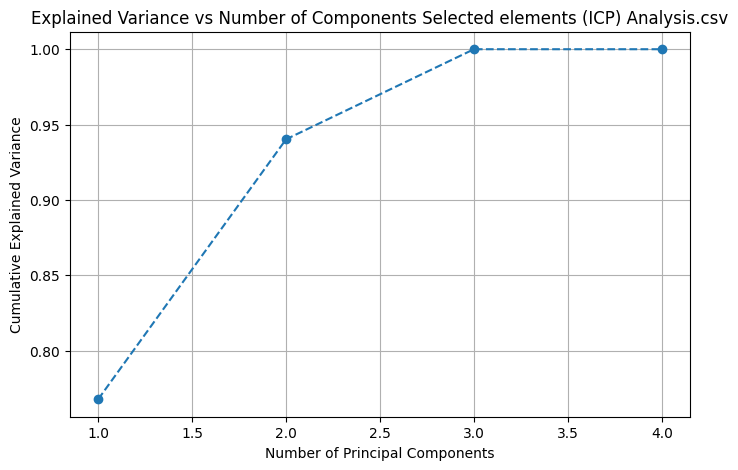

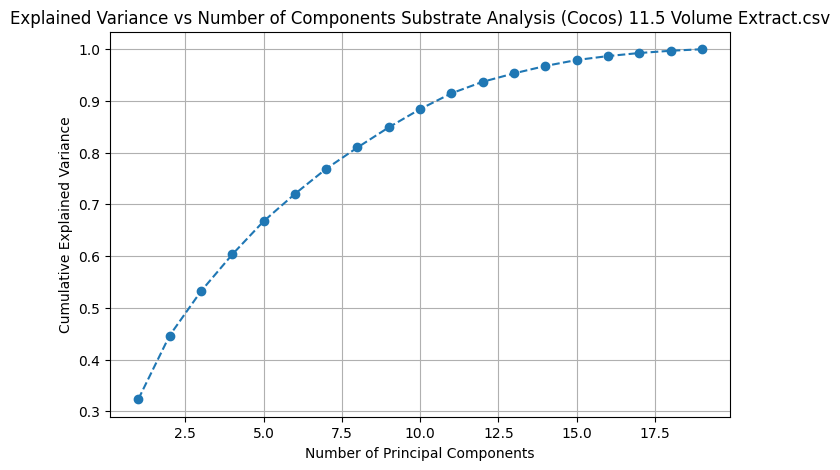

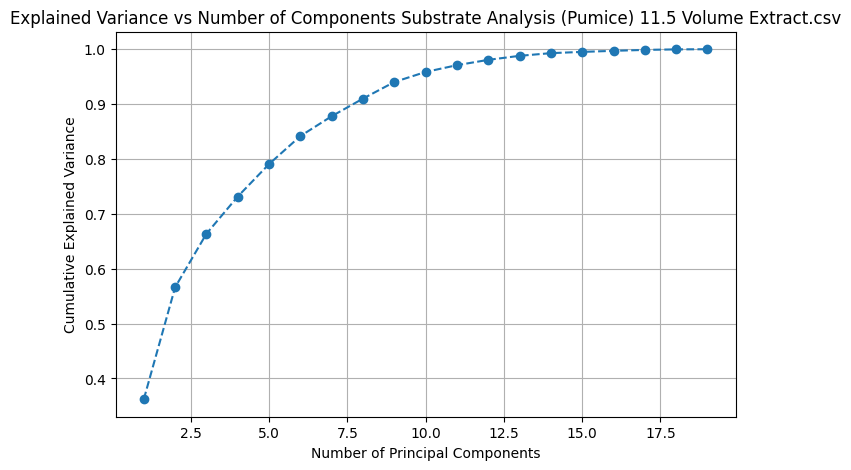

In [21]:
for analysis_file in os.listdir("output/analysis"):
    print(analysis_file)
    analysis_df = pd.read_csv(f"output/analysis/{analysis_file}",index_col=0)
    analysis_df = analysis_df.loc[analysis_df.index.isin(hydroponics_df.sample_code)]
    imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
    # analysis_df = pd.DataFrame(imp_mean.fit_transform(analysis_df), columns=analysis_df.columns, index=analysis_df.index)
    analysis_df = pd.DataFrame(imp_mean.fit_transform(analysis_df), index=analysis_df.index)
    analysis_df.to_csv(f"./output/analysis_imputed/{analysis_file}")
    pickle.dump(imp_mean, open(f"models/imputers/{analysis_file.replace('csv','pkl')}","wb"))
    # if(len(analysis_df) == 0):
    #     continue
    if(len(analysis_df.columns) == 1):
        continue
    sc = StandardScaler()
    pca = PCA()
    analysis_scaled = sc.fit_transform(analysis_df)
    pca.fit(analysis_scaled)
    explained_variance_ratio = pca.explained_variance_ratio_
    cumulative_explained_variance = np.cumsum(explained_variance_ratio)
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o', linestyle='--')
    plt.xlabel('Number of Principal Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.title(f'Explained Variance vs Number of Components {analysis_file}')
    plt.grid(True)
    plt.savefig(f"./output/pca_plots/{analysis_file.replace('.csv','.png')}")
    n_components = np.argmax(cumulative_explained_variance >= 0.95) + 1
    print(f'Number of components explaining 95% variance: {n_components}')
    
    pca = PCA(n_components=n_components)
    pca_reduced_df = pca.fit_transform(analysis_scaled)
    analysis_scaled = pd.DataFrame(analysis_scaled,index=analysis_df.index)
    analysis_scaled.to_csv(f"output/analysis_scaled/{analysis_file}")
    np.save(f"output/pca_df/{analysis_file.replace('.csv','')}", pca_reduced_df)
    pickle.dump(sc, open(f"models/scalers/{analysis_file.replace('csv','pkl')}","wb"))
    pickle.dump(pca, open(f"models/pca/{analysis_file.replace('csv','pkl')}","wb"))

In [22]:
os.makedirs("./output/mahalanobis_distance",exist_ok=True)

In [23]:
for analysis_file in os.listdir("output/pca_df"):
    print(analysis_file)
    pca_reduced_df = pd.DataFrame(np.load(f"output/pca_df/{analysis_file}"))
    if len(pca_reduced_df.columns) <= 2:
        continue
    mu = np.mean(pca_reduced_df, axis=0)
    sigma = np.cov(pca_reduced_df.T)
    pca_reduced_df['mahalanobis_distance'] = [distance.mahalanobis(pca_reduced_df.iloc[i], mu, np.linalg.inv(sigma)) for i in range(len(pca_reduced_df)) ]

    pd.DataFrame(pca_reduced_df).to_csv(f"output/mahalanobis_distance/{analysis_file.replace('.npy','')}.csv")

Drain Water Analysis.npy
Drip Water Analysis.npy
E coli & Total Coliforms.npy
Fluoride Analysis (Media).npy
Fluoride Analysis.npy
Heavy metals in Hydroponics.npy
Raw irrigation water analysis (for fertigation).npy
Recycle Water Analysis.npy
Selected elements (ICP) Analysis.npy
Substrate Analysis (Cocos) 11.5 Volume Extract.npy
Substrate Analysis (Pumice) 11.5 Volume Extract.npy


In [24]:
os.makedirs("output/mahanobis_distance_upper_quantile",exist_ok=True)
os.makedirs("output/mahalanobis_boxplots",exist_ok=True)

In [25]:
mahalanobis_threshold_dict = {}
for analysis_file in os.listdir("output/mahalanobis_distance"):
    print(analysis_file)
    analysis = analysis_file.replace(".csv","")
    mahalanobis_df = pd.read_csv(f"output/mahalanobis_distance/{analysis_file}",index_col=0)
    upper_quantile = (mahalanobis_df['mahalanobis_distance'].quantile(0.95))
    mahalanobis_threshold_dict[analysis_file.replace(".csv","")] = upper_quantile
    mahalanobis_df.loc[mahalanobis_df['mahalanobis_distance'] >= upper_quantile].to_csv(f"output/mahanobis_distance_upper_quantile/{analysis_file}")
    plt.boxplot(mahalanobis_df['mahalanobis_distance'])
    plt.axhline(y=upper_quantile, color='red', linestyle='--', label=f'Threshold at {upper_quantile}')
    plt.title(f"Mahalanobis Threshold = {round(upper_quantile,2)}")
    plt.savefig(f"output/mahalanobis_boxplots/{analysis}.png")
    plt.clf()
pickle.dump(mahalanobis_threshold_dict, open("mahalanobis_thresholds.dict","wb"))

Drain Water Analysis.csv
Drip Water Analysis.csv
Heavy metals in Hydroponics.csv
Raw irrigation water analysis (for fertigation).csv
Recycle Water Analysis.csv
Selected elements (ICP) Analysis.csv
Substrate Analysis (Cocos) 11.5 Volume Extract.csv
Substrate Analysis (Pumice) 11.5 Volume Extract.csv


<Figure size 640x480 with 0 Axes>

In [26]:
pd.DataFrame({'analysis_name':(mahalanobis_threshold_dict.keys())}).to_csv("output/analysis_names_send_to_thomas_and_josephine.csv")

In [16]:
conn_lims = pyodbc.connect("Driver={SQL Server};"
                            "Server=192.168.5.18\CROPNUT;"
                            "Database=cropnuts;"
                            "uid=thomasTsuma;pwd=GR^KX$uRe9#JwLc6")

In [17]:
reverse_analysis_dict = pd.read_sql(f"""SELECT analysis_id, LTRIM(RTRIM(analysis_name)) as analysis_name FROM Analysis ORDER BY analysis_name""",con=conn_lims).set_index("analysis_name").to_dict()['analysis_id']
reverse_analysis_dict

C:\Users\tsuma.thomas\AppData\Local\Temp\ipykernel_23420\3771434913.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  reverse_analysis_dict = pd.read_sql(f"""SELECT analysis_id, LTRIM(RTRIM(analysis_name)) as analysis_name FROM Analysis ORDER BY analysis_name""",con=conn_lims).set_index("analysis_name").to_dict()['analysis_id']


{'% Gypsum': 540,
 '% Nitrogen (RSSP 2)': 647,
 '% Organic Matter': 258,
 '% Organic Matter (RSSP 2)': 646,
 '% Soil Nitrogen': 18,
 '%Assay': 27490,
 '%N (RSSP 2)': 652,
 '%OM (RSSP 2)': 651,
 '%P,%S Analysis(Super Calcium)': 383,
 '1:2 Soil Volume Extract': 294,
 '1:2 soil volume extract': 25,
 '1:2 Soil Volume Extract (Data Only)': 27339,
 '1:2 Vol Extract for BLGG': 317,
 '20:12:12 (N,P205,K20) Analysis': 840,
 'Absorbance at 254nm': 26936,
 'Acid Detergent Fibre': 27063,
 'Acid Insoluble Ash': 27417,
 'Acid Insoluble Matter': 27108,
 'Acid titration': 26647,
 'Acid Value': 26971,
 'Advanced Biological Farming Soil Audit': 26521,
 'Advanced Soil Health Analysis': 27181,
 'Aerobic Mesophilic Count': 26649,
 'Aflatoxin': 26794,
 'Aflatoxin AFB1': 26938,
 'Aflatoxin B1': 26939,
 'Aflatoxin in feed': 767,
 'Aflatoxin M1': 27469,
 'Aflatoxin Total': 766,
 'AfSIS Standard Leaf Analysis': 633,
 'AFSIS Std Wet Chemistry Soil Analysis': 589,
 'Aggregate Stability': 26727,
 'Agrifi Soil Micr

In [18]:
for analysis in reverse_analysis_dict.copy().keys():
    if ":" in analysis:
        reverse_analysis_dict[analysis.replace(":","")] = reverse_analysis_dict[analysis]

In [19]:
test = []

In [20]:
new_samples = pd.read_sql(f"SELECT sample_code, batch_date, result, unit_name, chemical_name, analysis_name FROM SampleResults WHERE sample_code IN {tuple(new_samples_df.sample_code.values)}", con=conn_lims)

C:\Users\tsuma.thomas\AppData\Local\Temp\ipykernel_23420\1881003016.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  new_samples = pd.read_sql(f"SELECT sample_code, batch_date, result, unit_name, chemical_name, analysis_name FROM SampleResults WHERE sample_code IN {tuple(new_samples_df.sample_code.values)}", con=conn_lims)


In [21]:
new_samples = new_samples.dropna(subset=['chemical_name','result','analysis_name'])
new_samples['analysis_name'] = [ str(i).replace(":","").split(",") for i in new_samples.analysis_name ]
new_samples = new_samples.explode("analysis_name")

In [22]:
new_samples['result'] = [ str(i).replace("<","").replace(">","").strip() for i in new_samples['result'] ]

In [23]:
new_samples.loc[(new_samples['result'] == "ND"), "result" ] = 0

In [24]:
new_samples = new_samples.loc[~(new_samples['result'] == "Detected") ]

In [25]:
new_samples['unit_name'] = [ str(i).strip() for i in new_samples['unit_name'].values ]

In [26]:
new_samples['chemical_name'] = [ str(i).lower().replace(" ","_").replace("(","").replace(")","").replace(".","").strip() for i in new_samples['chemical_name'].values ]

In [27]:
new_samples['result'] = new_samples['result'].astype(float)

In [28]:
test = []
for sample in new_samples.sample_code.unique():
    res = {}
    tmp_ = new_samples.loc[new_samples.sample_code == sample]
    res['sample_code'] = sample
    print([ i for i in tmp_.analysis_name.unique() ])
    res['analysis_id'] = [ reverse_analysis_dict[i] for i in tmp_.analysis_name.unique() if i in reverse_analysis_dict.keys() ]
    for index,row in tmp_.iterrows():
        if row['result'] >= 0 :
            res[row['chemical_name']] = {'result': row['result'], 'units': str(row['unit_name'])}
        else:
            res[row['chemical_name']] = {'result': 0, 'units': row['unit_name']}
    test.append(res)    


['Drain Water Analysis']
['Drip Water Analysis']
['Drain Water Analysis']
['Substrate Analysis (Cocos) 11.5 Volume Extract']
['Drip Water Analysis']
['Drip Water Analysis']
['Drain Water Analysis']
['Drip Water Analysis']
['Drain Water Analysis']
['Drip Water Analysis']
['Drain Water Analysis']
['Drip Water Analysis']
['Drain Water Analysis']
['Drain Water Analysis']
['Drip Water Analysis']
['Drain Water Analysis']
['Substrate Analysis (Cocos) 11.5 Volume Extract']
['Substrate Analysis (Cocos) 11.5 Volume Extract']
['Drip Water Analysis']
['Drain Water Analysis']
['Drip Water Analysis']
['Recycle Water Analysis']
['Raw irrigation water analysis (for fertigation)']
['Drip Water Analysis']
['Drain Water Analysis']
['Drip Water Analysis']
['Drip Water Analysis']
['Drain Water Analysis']
['Drip Water Analysis']
['Drain Water Analysis']
['Drain Water Analysis']
['Drip Water Analysis']
['Drain Water Analysis']
['Substrate Analysis (Pumice) 11.5 Volume Extract']
['Raw irrigation water analysi

In [29]:
len(test)

1098

In [30]:
# reverse_analysis_dict['1:2 Soil Volume Extract'] 

In [31]:
analysis_dict = pd.read_sql(f"""SELECT analysis_id, LTRIM(RTRIM(analysis_name)) as analysis_name FROM Analysis  ORDER BY analysis_name""",con=conn_lims).set_index("analysis_id").to_dict()['analysis_name']

C:\Users\tsuma.thomas\AppData\Local\Temp\ipykernel_23420\132348878.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  analysis_dict = pd.read_sql(f"""SELECT analysis_id, LTRIM(RTRIM(analysis_name)) as analysis_name FROM Analysis  ORDER BY analysis_name""",con=conn_lims).set_index("analysis_id").to_dict()['analysis_name']


In [32]:
pickle.dump(analysis_dict, open("analysis.dict","wb"))

In [33]:
analysis_dict = pickle.load(open("analysis.dict","rb"))

In [34]:
mahalanobis_thresholds = pickle.load(open("mahalanobis_thresholds.dict","rb"))

In [35]:
pd.DataFrame({'analysis_name':mahalanobis_thresholds.keys()}).to_csv("output/analyses_in_models.csv")

In [36]:
unit_decision = pd.read_csv("output/sgf_unit_per_chemical_decision.csv")

In [38]:
req_body = test
_ = pd.DataFrame(req_body)
unit_decision = pd.read_csv("output/sgf_unit_per_chemical_decision.csv")
unit_decision.analysis_name = [ i.replace(":","") for i in unit_decision.analysis_name ]
analysis_dict = pickle.load(open("analysis.dict","rb"))
mahalanobis_thresholds = pickle.load(open("mahalanobis_thresholds.dict","rb"))

result = {}
_df = _.explode('analysis_id', ignore_index=True)
import math
for index,row in _df.iterrows():
    sample_code = row['sample_code']
    if sample_code not in result.keys():
        result[sample_code] = []
    if math.isnan(row['analysis_id']):
        result[sample_code].append({"sample_code": sample_code,"status":"warning", "message": f"Analysis not in specified", "details": f"Analysis id not provided", "analysis": None  })   
        continue
    row['analysis_name'] = analysis_dict[row['analysis_id']]
    analysis = row['analysis_name'].replace(":","")
    analysis_id = row['analysis_id']
    if analysis not in mahalanobis_thresholds.keys():
        result[sample_code].append({"sample_code": sample_code,"status":"warning", "message": f"Analysis not in models", "details": f"Analysis: {analysis} is not in the list of defined models", "analysis": row['analysis_name'] })   
        continue  
    row = row.dropna()
    scaler = pickle.load(open(f"models/scalers/{analysis}.pkl","rb"))
    pca = pickle.load(open(f"models/pca/{analysis}.pkl","rb"))
    imputer = pickle.load(open(f"models/imputers/{analysis}.pkl","rb"))
    analysis_df = pd.read_csv(f"output/analysis/{analysis}.csv",index_col=0)

    analysis_df = analysis_df.loc[:, ~analysis_df.columns.duplicated()]

    mahalanobis_distance_df = pd.read_csv(f"output/mahalanobis_distance/{analysis}.csv",index_col=0).drop("mahalanobis_distance",axis=1)

    

    try :
        tmp_df = pd.DataFrame(row).T[analysis_df.columns]
    except Exception as e:
        result[sample_code].append({"sample_code": sample_code,"status":"warning", "message": f"Missing parameters for analysis: {analysis}", "details": f"Missing parameters: {','.join([ i for i in analysis_df.columns if i not in row.dropna().index])} for analysis: {analysis}", "analysis": row['analysis_name']})
        continue
    failed_units_comparison = {}    
    for col in tmp_df.columns:
        expected_units = unit_decision.loc[(unit_decision['analysis_name'] == analysis) & (unit_decision['chemical_name'] == col)]
    
        import math
        if type(row[col]) != dict and math.isnan(row[col]):
            failed_units_comparison[col] = {}
            failed_units_comparison[col]['expected_units'] = expected_units['unit_name'].tolist()[0]
            failed_units_comparison[col]['units_provided'] = None
        elif row[col]['units'] !=   expected_units['unit_name'].values[0] :
            failed_units_comparison[col] = {}
            failed_units_comparison[col]['expected_units'] = expected_units['unit_name'].tolist()[0]
            failed_units_comparison[col]['units_provided'] = row[col]['units']
        else:
            continue    
    if len(failed_units_comparison.keys()) > 0:
        result[sample_code].append({"sample_code": sample_code,"status":"warning", "message": f"Wrong units provided", "details": f"Expected units are {str(failed_units_comparison)} for analysis: {analysis}" , "analysis": row['analysis_name']})
        continue
    for col in analysis_df.columns:
        if type(row[col]) == dict:
            row[col] = row[col]['result']
    
    out_of_bounds_chems = [ ]
    for col in tmp_df.columns:
        if col == "sample_code":
            continue
        if col == "ec_salts":
            if row[col] > 105 or row[col] < 95:
                out_of_bounds_chems.append("ec_salts out of bounds. Allowed bounds are 95 - 105")
        if col == "Charge Balance":
            if row[col] < -1:
                out_of_bounds_chems.append("Charge Balance out of bounds. Allowed lower boundary is -10. ")       
        elif col.lower() == "total suspended solids" and row['analysis_name'].lower() == "total suspended solids":
            if row[col] > 1:
                out_of_bounds_chems.append("total suspended solids out of bounds. If analysis is total suspended solids is <1 then total suspended solids check should be <1  . ")         
    if len(out_of_bounds_chems) > 0:
        result[sample_code].append({"sample_code": sample_code,"status":"warning", "message": f"Out of bounds", "details": f"{'.'.join(out_of_bounds_chems)}", "analysis": row['analysis_name'] })
        continue    

    tmp_df = pd.DataFrame(row).T[analysis_df.columns]
    tmp_df = imputer.transform(tmp_df)
    df_scaled = scaler.transform(tmp_df)
    df_pca = pd.DataFrame(pca.transform(df_scaled))
    
    df_pca.columns = [ i for i in df_pca.columns]
    mahalanobis_distance_df.columns = [ i for i in df_pca.columns]
    df_pca = pd.concat([df_pca, mahalanobis_distance_df])
    mu = np.mean(df_pca, axis=0)
    sigma = np.cov(df_pca.T)

    mahalanobis_distance = distance.mahalanobis(df_pca.iloc[0], mu, np.linalg.inv(sigma))

    expected_md = mahalanobis_thresholds[analysis]

    if mahalanobis_distance > expected_md:
        result[sample_code].append({"sample_code": sample_code,"status":"fail", "message": "Mahalanobis distance exceeds threshold", "details":f"Mahalanobis distance of {round(mahalanobis_distance,2)} exceeds threshold of {round(expected_md,2)} for analysis: {analysis}", "analysis": row['analysis_name'] })
    else:
        result[sample_code].append({"sample_code": sample_code,"status":"pass","message": "Mahalanobis distance within threshold", "details":f"Mahalanobis distance of {round(mahalanobis_distance,2)} is within threshold of {round(expected_md,2)} for analysis: {analysis}", "analysis": row['analysis_name'] })
          

In [ ]:
final_df = pd.DataFrame()
for i in result.keys():
    out_df = (pd.DataFrame(result[i]))
    final_df = pd.concat([final_df, out_df])


In [ ]:
final_df.to_csv("test_results.csv")

In [ ]:
final_df